In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes

import umap
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore") 
%matplotlib inline

pd.set_option('display.max_columns', None)

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
data = pd.read_excel(r"C:\Users\KanamarlapudiVenkate\Downloads\Aspen\20210604 - Yield Analysis Clustering - Office Details (April, 2021).xlsx", engine='openpyxl')
data.head()

,FacilityCode,Facility Name,Office Status,Sqft,Open Date,Current Working Year,NPA Benchmarks,TotalRevenue,EBITDA,TotalRevenuePerHour,EBITDAPerHour,Exclude Data,NPRevenue,Primary Lender,Primary Chair,Secondary Chair,Total Employee,Clinic,Technicians,Services,% AfricanAmerican,% Hispanic,% Uninsured,Median Normalised Income,Ext Comp Within 20 Miles,Aspen Within 20 Miles,Clusters,Office Class,POP Owner,CVS Walgreens (.25mi),Fast Cas. Mexican Burger (.25mi),Shop. Center GLA (1.5mi),Big Box Retailers (1.5mi),"Highway Exit (.5mi)\n1=Yes, 0=No",Housing Value Ratio (1/15mi),High School Graduates (5-7-10mi),Employees (3mi),% HH Income $200K+ (5mi),% Veterans (20mi),% Speaking Only English (20mi),Median Age (20mi),% Rural Industries (10mi),% High School or Less (15mi),% Black (10mi),% No Health Insur. (10mi),% Medicaid (10mi),Dental Chains (1mi),Delta Dental per 10K (10mi),Years in DMA,NPS,NP Yes Today
0,5.0,"Farmington, CT",Open,3750.0,1999-09-09,22.0,7.677060,141796.21,20080.81,310.106528,43.916479,Include,73974.39,CareCredit,4.0,1.0,7.0,5.0,1.0,1.0,0.148,0.199,0.0499,76467.64,463.0,6.0,High Competition,Suburban,POP,0.0,0.0,1781005.0,1.0,1.0,0.9,74088.0,43876.0,0.0544,0.0604,0.7682,41.8,0.0520,0.3851,0.1484,0.0499,0.2192,0.0,3.8,31.0,0.4,0.43
1,19.0,"Seekonk, MA",Open,4000.0,1999-09-09,22.0,7.547576,209383.56,43090.87,388.106691,79.871863,Include,112338.21,DentalFirst Financing,4.0,1.0,11.0,7.0,2.0,2.0,0.068,0.179,0.0583,66714.48,293.0,6.0,Low uninsured,Suburban,POP,0.0,0.0,895999.0,3.0,1.0,1.3,78067.0,23603.0,0.0552,0.0672,0.7789,41.4,0.0524,0.4348,0.0682,0.0583,0.2221,0.0,1.9,31.0,0.4,0.43
2,21.0,"Fall River, MA",Open,3952.0,1999-09-09,22.0,6.762903,263818.56,54684.74,403.084125,83.551933,Include,107463.23,DentalFirst Financing,5.0,1.0,15.0,11.0,1.0,3.0,0.022,0.043,0.0302,72641.37,289.0,7.0,Low uninsured,Urban,POP,2.0,0.0,934543.0,0.0,1.0,0.9,29560.0,29231.0,0.0169,0.0656,0.7494,40.8,0.0734,0.4447,0.0221,0.0302,0.2179,1.0,2.5,31.0,0.4,0.43
3,21.0,"Fall River, MA (Relo)",Open,3952.0,1999-09-09,22.0,6.762903,263818.56,54684.74,403.084125,83.551933,Include,107463.23,DentalFirst Financing,5.0,1.0,15.0,11.0,1.0,3.0,0.022,0.043,0.0303,72641.37,289.0,5.0,Low uninsured,Urban,POP,1.0,1.0,934543.0,0.0,1.0,0.9,29023.0,26993.0,0.0175,0.0654,0.7480,40.8,0.0733,0.4433,0.0221,0.0302,0.2189,1.0,2.5,31.0,0.4,0.43
4,30.0,"Fairfield, CT",Open,3687.0,2000-02-14,22.0,5.142188,169954.62,30235.60,309.008400,54.973818,Include,64232.94,CareCredit,5.0,1.0,10.0,7.0,1.0,2.0,0.145,0.192,0.0791,93421.40,452.0,3.0,High Median Income,Most Urban,LGP,1.0,0.0,0.0,0.0,0.0,1.4,38201.0,38940.0,0.0968,0.0469,0.7265,40.8,0.0623,0.3308,0.1443,0.0791,0.1946,0.0,3.8,31.0,0.4,0.43


In [3]:
data.drop_duplicates(subset=['FacilityCode'], inplace=True, ignore_index=True)

data.drop(['NPS', 'NP Yes Today','Facility Name', 'Office Status','Open Date','TotalRevenue', 'EBITDA', 'Primary Lender',
           'POP Owner','Exclude Data','NPRevenue', 'High School Graduates (5-7-10mi)', '% AfricanAmerican'], axis=1, inplace=True)

data.rename({"Highway Exit (.5mi)\n1=Yes, 0=No" : "Highway Exit (.5mi)",
             "% Black (10mi)" : "% AfricanAmerican"}, axis=1, inplace=True)

In [4]:
data['Sqft'].fillna(data['Sqft'].median(), inplace=True)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [5]:
model_cols = ['Office Class', 'Sqft', 'Current Working Year', 'NPA Benchmarks', 'Primary Chair', 'Secondary Chair',
              'Total Employee', 'Clinic', 'Technicians', 'Services', 'Median Normalised Income', 'Ext Comp Within 20 Miles',
              'Aspen Within 20 Miles', 'CVS Walgreens (.25mi)', 'Fast Cas. Mexican Burger (.25mi)',
              'Shop. Center GLA (1.5mi)', 'Big Box Retailers (1.5mi)', 'Highway Exit (.5mi)', 'Housing Value Ratio (1/15mi)',
              'Employees (3mi)', 'Dental Chains (1mi)', 'Delta Dental per 10K (10mi)', 'Years in DMA', 'Median Age (20mi)', 
              '% HH Income $200K+ (5mi)', '% Veterans (20mi)', '% Speaking Only English (20mi)', '% Rural Industries (10mi)',
              '% High School or Less (15mi)', '% No Health Insur. (10mi)', '% Medicaid (10mi)',
              '% AfricanAmerican', '% Hispanic', '% Uninsured']

rem_cols = ['FacilityCode', 'Clusters', 'TotalRevenuePerHour', 'EBITDAPerHour']

In [6]:
# data[model_cols].describe(percentiles=(.75,.9,.95,.99,.999))

### Outlier Treatment

In [7]:
# Capping att 99-percentile
outlier_cols = ['Sqft', 'Median Normalised Income', 'Ext Comp Within 20 Miles', 'Shop. Center GLA (1.5mi)', 'Employees (3mi)']

data[outlier_cols] = np.where(data[outlier_cols]>data[outlier_cols].quantile(0.99),
                         data[outlier_cols].quantile(0.99),
                         data[outlier_cols])

### Normalize

In [8]:
pt = PowerTransformer()
cols = data[model_cols].select_dtypes(exclude='object').columns

df_scaled = data[model_cols].copy()
df_scaled[cols] = pt.fit_transform(df_scaled[cols])
df_scaled.head()

,Office Class,Sqft,Current Working Year,NPA Benchmarks,Primary Chair,Secondary Chair,Total Employee,Clinic,Technicians,Services,Median Normalised Income,Ext Comp Within 20 Miles,Aspen Within 20 Miles,CVS Walgreens (.25mi),Fast Cas. Mexican Burger (.25mi),Shop. Center GLA (1.5mi),Big Box Retailers (1.5mi),Highway Exit (.5mi),Housing Value Ratio (1/15mi),Employees (3mi),Dental Chains (1mi),Delta Dental per 10K (10mi),Years in DMA,Median Age (20mi),% HH Income $200K+ (5mi),% Veterans (20mi),% Speaking Only English (20mi),% Rural Industries (10mi),% High School or Less (15mi),% No Health Insur. (10mi),% Medicaid (10mi),% AfricanAmerican,% Hispanic,% Uninsured
0,Suburban,0.900078,2.018926,-0.670438,-1.071551,0.0,-1.883222,-1.038058,-0.469686,-2.611871,0.396025,1.181009,1.430220,-0.518812,-0.797541,0.985737,-0.398544,1.287469,-0.243519,0.940047,-0.660735,0.912377,2.24011,0.622546,1.334326,-1.220192,-1.294187,-1.065349,-0.136832,-1.008033,0.925782,0.637807,1.390337,-1.008033
1,Suburban,1.622680,2.018926,-0.732438,-1.071551,0.0,-0.273053,-0.088250,1.086638,-1.349993,-0.385459,0.761589,1.430220,-0.518812,-0.797541,0.109144,1.401311,1.287469,1.241189,0.035700,-0.660735,-1.117743,2.24011,0.520969,1.357907,-0.792950,-1.222092,-1.037010,0.516025,-0.720190,0.972804,-0.285843,1.267809,-0.720190
2,Urban,1.490526,2.018926,-1.115853,0.093686,0.0,0.990808,1.467175,-0.469686,-0.270924,0.106121,0.749169,1.592124,1.959789,-0.797541,0.155928,-1.613483,1.287469,-0.243519,0.342492,1.456531,-0.426547,2.24011,0.363391,-0.804382,-0.889455,-1.408465,0.187575,0.641206,-1.759870,0.904582,-1.094956,-0.582897,-1.759870
3,Most Urban,0.703675,2.018926,-1.956509,0.093686,0.0,-0.634849,-0.088250,-0.469686,-1.349993,1.481353,1.158677,0.727433,1.922152,-0.797541,-2.507847,-1.613483,-0.776718,1.545675,0.762396,-0.660735,0.912377,2.24011,0.363391,2.041884,-2.215595,-1.528598,-0.399632,-0.900393,-0.080773,0.511413,0.601417,1.349923,-0.080773
4,Suburban,-1.314892,1.715087,-2.241154,0.093686,0.0,-1.883222,-1.581794,-0.469686,-1.349993,2.252205,1.196939,0.350387,-0.518812,-0.797541,-2.507847,-1.613483,-0.776718,0.559032,0.431471,-0.660735,1.197727,2.24011,0.721458,2.299476,-2.365021,-1.582340,-0.624062,-1.322649,0.047804,-1.403941,-0.317330,0.963749,0.047804


### UMAP - Normalized Data

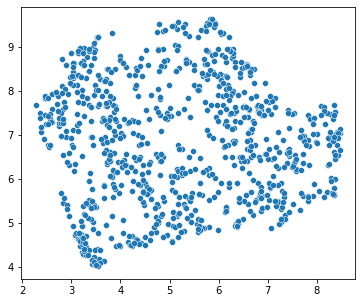

In [9]:
embedding_scaled = umap.UMAP(n_neighbors=15, random_state=42, min_dist=.01, metric='euclidean', target_n_neighbors=5, n_epochs=500).fit_transform(df_scaled.select_dtypes(exclude='object'))

plt.figure(figsize=(6,5))
sns.scatterplot(embedding_scaled[:, 0], embedding_scaled[:, 1], palette='Dark2')

# tsne = TSNE(random_state = 42, n_components=3,verbose=0, perplexity=20, n_iter=400).fit_transform(df_scaled.select_dtypes(exclude='object'))
# sns.scatterplot(tsne[:, 0], tsne[:, 1], palette='Dark2')

### KPrototype

In [10]:
# Convert dataframe to matrix
dfMatrix = df_scaled.to_numpy()

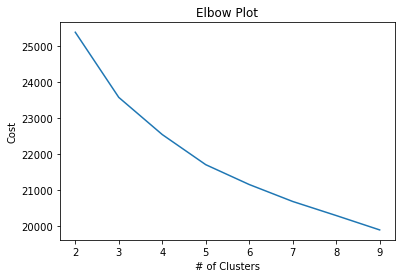

,# of Clusters,silhouette_score
0,2,0.10
1,3,0.09
2,4,0.08
3,5,0.07
4,6,0.07
5,7,0.07
6,8,0.06
7,9,0.06


In [11]:
# Choose optimal K using Elbow method
cost = []
scores = []

for cluster in range(2, 10):
    kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Cao', random_state = 42)
    kprototype.fit_predict(dfMatrix, categorical = [0])
    cost.append(kprototype.cost_)
    scores.append(silhouette_score(dfMatrix[:, 1:], kprototype.labels_))
    
sns.lineplot(range(2,10), cost)
plt.xlabel("# of Clusters")
plt.ylabel("Cost")
plt.title("Elbow Plot")
plt.show()

# Silhouette scores for different k values
table = pd.DataFrame({'# of Clusters':range(2,10), 'silhouette_score':['%.2f' % x for x in scores]})
table

In [12]:
# Fitting K-prototype to the dataset
kprototype = KPrototypes(n_clusters = 5, init = 'Huang', random_state = 42, n_jobs = -2, gamma=0.49, max_iter=1000)
clusters = kprototype.fit_predict(dfMatrix, categorical = [0])
pd.Series(clusters).value_counts()

3    189
0    187
2    176
4    169
1    156
dtype: int64

### Evaluate

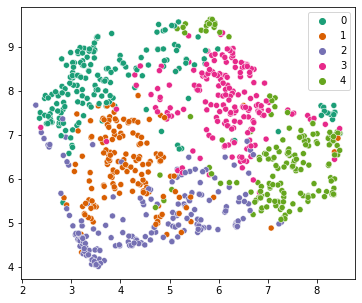

In [13]:
plt.figure(figsize=(6,5))
sns.scatterplot(embedding_scaled[:, 0], embedding_scaled[:, 1], hue=clusters, palette='Dark2')

In [14]:
#Setting the objects to category 
lgbm_data = data[model_cols].copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

In [15]:
clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, clusters, cv=5, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Prototypes clusters is 0.8677493496002342


In [16]:
clf_kp.fit(lgbm_data, clusters)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


LGBMClassifier(colsample_by_tree=0.8)

In [17]:
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)

C extension was not built during install!


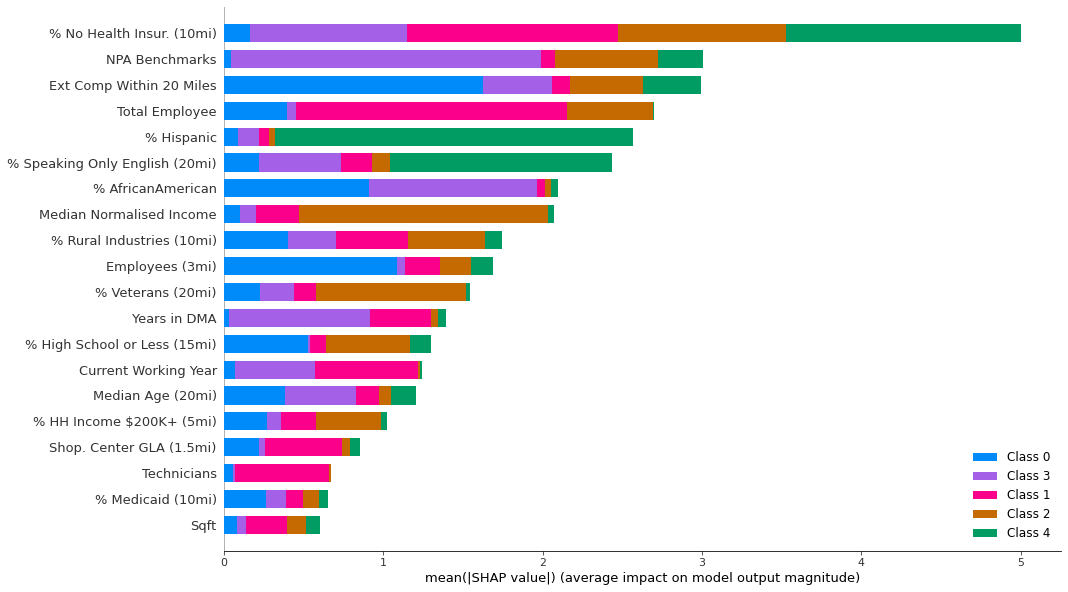

In [18]:
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(15, 10))

### Results

In [19]:
df_scaled_clusters = data[model_cols].copy()
df_scaled_clusters['Cluster_ID'] = clusters
df_scaled_clusters = pd.concat([df_scaled_clusters, data[rem_cols]], axis = 1)
df_scaled_clusters['Cluster_ID'].value_counts()

3    189
0    187
2    176
4    169
1    156
Name: Cluster_ID, dtype: int64

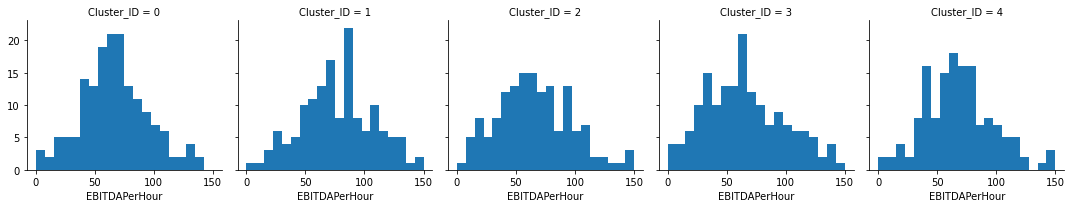

In [20]:
grid = sns.FacetGrid(df_scaled_clusters, col='Cluster_ID')
grid.map(plt.hist, 'EBITDAPerHour', range=[0,150], bins=20)

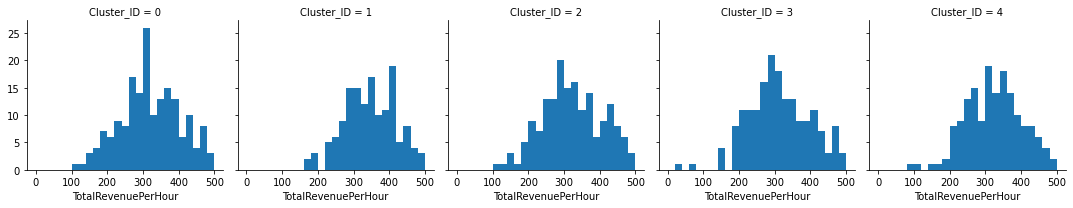

In [21]:
grid = sns.FacetGrid(df_scaled_clusters, col='Cluster_ID')
grid.map(plt.hist, 'TotalRevenuePerHour', range=[0,500], bins=25)

In [22]:
df_scaled_clusters.groupby('Cluster_ID').agg(
    {
        'EBITDAPerHour' : ['min', 'max', 'median', 'mean'],
        'TotalRevenuePerHour' : ['min', 'max', 'median', 'mean']
    }
).reset_index().round(2)

Cluster_ID EBITDAPerHour                       TotalRevenuePerHour          \
                       min     max median   mean                 min     max   
0          0      -2797.22  203.19  63.47  38.53              118.17  786.32   
1          1        -14.80  253.99  79.32  83.29              172.71  764.12   
2          2       -132.23  581.12  62.66  67.88              110.11  554.63   
3          3      -3826.76  267.89  60.75  42.56               23.43  621.82   
4          4       -136.75  208.98  62.70  58.93               87.92  571.81   

                   
   median    mean  
0  316.57  332.26  
1  349.32  362.88  
2  320.60  326.67  
3  308.20  326.06  
4  323.01  330.87